In [2]:
#imports
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import seaborn as sns

from PathFinder import find_path

In [3]:
#read data
PATH = find_path()

#select files
#files = ['application_train.csv','application_test.csv',]
files = ['preprocessed_train.csv', 'preprocessed_test.csv']
"""         
          'bureau.csv', 
         'bureau_balance.csv', 'credit_card_balance.csv',
         'installments_payments.csv', 'POS_CASH_balance.csv',
         'previous_application.csv']
"""
data_files=[]
data=[]
print("files used: {}".format(files))

#actually read files
for file in files:
    stuff = pd.read_csv(PATH+file,header=0,engine='python')
    #print(stuff)
    data_files.append(file)
    data.append(stuff)

files used: ['preprocessed_train.csv', 'preprocessed_test.csv']


In [4]:
#select and convert columns
original_train = data[0] #save the original because we'll need some stuff later
original_test = data[1]
app_train = data[0].copy()
app_test = data[1].copy()

#delete ID cols
del app_train['SK_ID_CURR']
del app_test['SK_ID_CURR']

app_train_y = app_train['TARGET']
new_cols_x = app_train.columns.values.tolist()
new_cols_x.remove('TARGET')
app_train_x = app_train[new_cols_x]

print('Training Features shape: ', app_train_x.shape) #235 cols
print('Testing Features shape: ', app_test.shape) #235 cols

Training Features shape:  (307511, 235)
Testing Features shape:  (48744, 235)


In [5]:
#PCA
from sklearn.decomposition import PCA

#pca = PCA() #default n_components=235
#pca = PCA(n_components=1) #possibility
pca = PCA(n_components=2) #possibility
X_train_pca = pca.fit_transform(app_train_x)
X_test_pca = pca.transform(app_test)
#X_train_pca
#X_train_pca.shape #(307511, 235), changes with n_components

In [6]:
#new dataframe for plotting
df = pd.DataFrame({'TARGET': app_train_y, 'PCA_c1': X_train_pca[:,0]})
#df = pd.DataFrame({'TARGET': app_train_y, 'PCA_c1': X_train_pca[:,5]}) #all similar pattern
df.head()

,TARGET,PCA_c1
0,1,-0.640670
1,0,0.234180
2,0,-0.719401
3,0,-0.480250
4,0,-0.909226


C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


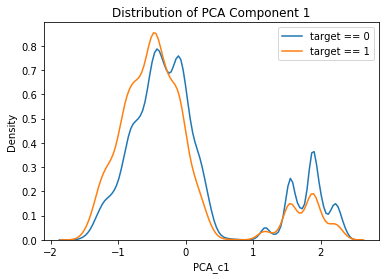

In [7]:
#plot PCA/Target correlation
#no wonder PCA is so horrible
#plt.figure(figsize = (10, 8))
plt.figure()

# KDE plot of loans that were repaid on time
sns.kdeplot(df.loc[df['TARGET'] == 0, 'PCA_c1'], label = 'target == 0')

# KDE plot of loans which were not repaid on time
sns.kdeplot(df.loc[df['TARGET'] == 1, 'PCA_c1'], label = 'target == 1')

# Labeling of plot
plt.xlabel('PCA_c1'); plt.ylabel('Density'); plt.title('Distribution of PCA Component 1');

In [8]:
from matplotlib.colors import ListedColormap

def plot_decision_regions(X, y, classifier, resolution=0.02, plot_samples=True):

    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())
    #plt.xlim(-10, 10)
    #plt.ylim(-10, 10)

    # plot class samples
    if plot_samples:
        for idx, cl in enumerate(np.unique(y)):
            plt.scatter(x=X[y == cl, 0], 
                        y=X[y == cl, 1],
                        alpha=0.6, 
                        c=cmap(idx),
                        edgecolor='black',
                        marker=markers[idx], 
                        label=cl)
            break

In [10]:
#apply logistic regression
from sklearn.linear_model import LogisticRegression

# Make the model with the specified regularization parameter
log_reg = LogisticRegression(random_state=20)

# Train on the training data
#log_reg.fit(app_train_x, app_train_y)
log_reg.fit(X_train_pca, app_train_y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=20, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

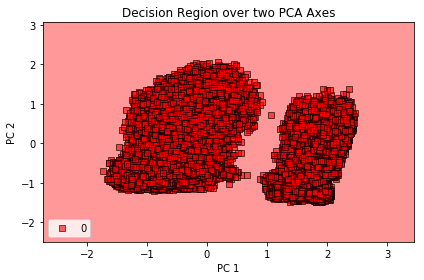

In [11]:
#only works with n_components=2
plot_decision_regions(X_train_pca, app_train_y, classifier=log_reg, plot_samples=True)
#plt.xlim(-10, 10)
#plt.ylim(-10, 10)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.title('Decision Region over two PCA Axes')
plt.tight_layout()
# plt.savefig('images/05_04.png', dpi=300)
plt.show()

In [35]:
X_train_pca.shape

(307511, 2)

In [6]:
# Make predictions
# Make sure to select the second column only
log_reg_pred = log_reg.predict_proba(X_test_pca)[:, 1]

In [7]:
# Submission dataframe
submit = original_test[['SK_ID_CURR']]
submit['TARGET'] = log_reg_pred

submit.head()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,SK_ID_CURR,TARGET
0,100001,0.140757
1,100005,0.152993
2,100013,0.151315
3,100028,0.140491
4,100038,0.165416


In [8]:
# Save the submission to a csv file
overwrite = True
if overwrite:
    submit.to_csv('results/log_reg_pca_1.csv', index = False)

Submitted to kaggle  
log_reg_pca_0.csv created with PCA()  
score: 0.60208  
  
log_reg_pca_1.csv created with PCA(n_components=1)  
score: 0.61063

In [42]:
print(log_reg.coef_.shape)

(1, 2)


In [43]:
print('intercept:', log_reg.intercept_[:,None][0][0])
print('weights:',log_reg.coef_[0])
#np.hstack((log_reg.intercept_[:,None], log_reg.coef_))
#print('weights:')
#for feature, weight in zip(new_cols_x, log_reg.coef_[0]):
#    #print('{:3.7} {}'.format(weight, feature))
#    print(f'{weight} {feature}')

intercept: -1.8238251587286403
weights: [-0.14997385 -0.08555949]
